<a href="https://colab.research.google.com/github/a-agmon/experiments/blob/master/ScaleSkewedDataAWSipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

### 1. Load the data

In [0]:
df = pd.read_csv("capture20110810.binetflow")
print(f"Data size:{len(df.index)}\n")
display(df.head(3))

Data size:2824636



,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background


### 2. Some feature engineering ( mostly encoding categorical features and grouping less frequent data)




In [0]:
# Lets start with some preprocessing 

from sklearn import preprocessing

# We know the infected system IP addr so lets add it 

infected_addr = "147.32.84.165"
df["Bot"] = np.where(df['SrcAddr'] == infected_addr, 1, 0)

# Drop unnecessary columns
df = df.drop(columns=['SrcAddr','DstAddr','TotBytes','Sport','Dport','StartTime','sTos','dTos', 'Label'])

#fill nulls
for feature_name in df.columns:
    if df[feature_name].isnull().values.sum() > 0:
        val = "none" if df[feature_name].dtypes == object else -1 
        print(f"Filling nulls with value:{val} in column:{feature_name}")
        df[feature_name] = df[feature_name].fillna(value=val)
        

# define some encoding functions
def encode_field(df,field):
    encoder = preprocessing.LabelEncoder()
    print(f"encoding field:{field}")
    return  encoder.fit_transform(df[field])

def hot_encode(df, feature):
    return pd.get_dummies(
            encode_field(df, feature), prefix=feature, drop_first=True)

def group_less_frequent_values(df, feature, min_prc):
    categories = df[feature].value_counts()    
    for category in categories.index:                
        # how many times this category shows in the DS?
        freq = categories[category]        
        # if less than what we want (min_prc)
        if(freq < min_prc):
            new_val = "LF" if df[feature].dtypes == object else 99
            df.loc[df[feature] == category, feature] = new_val
 
# process the categorical features        
categorical_features = ['State','Proto','Dir']
# classes that are not frequent in the data (less than 1%) will be grouped. 
one_p = 0.01 * len(df.index) 
#loog through the categorical 
for feature in categorical_features:
    #group the less frequent ones
    group_less_frequent_values(df, feature, one_p)
    #index and then hot encode
    df = pd.concat([df, hot_encode(df,feature)],axis=1)
    

## now remove what we dont need 
df = df.drop(columns=categorical_features)



Filling nulls with value:none in column:State
encoding field:State
encoding field:Proto
encoding field:Dir


In [0]:
# irrelevant was dropped, categorical data was hot encoded 
display(df.head(5))

,Dur,TotPkts,SrcBytes,Bot,State_1,State_2,State_3,State_4,State_5,State_6,Proto_1,Proto_2,Proto_3,Dir_1,Dir_2
0,3550.182373,12,413,0,0,0,0,0,0,0,0,0,1,1,0
1,0.000883,2,75,0,0,0,0,0,0,0,0,0,1,1,0
2,0.000326,2,60,0,0,0,1,0,0,0,0,1,0,0,1
3,0.056966,3,120,0,0,0,1,0,0,0,0,1,0,0,1
4,3427.768066,42,1596,0,0,0,0,0,0,0,0,0,1,1,0


#### As you can see, we have a bunch of hot encoded categorical features and 3 numerical features. The variance and range of the numerical features vary quite a bit, and we will shortly deal with that. First, we need to addres a more problematic issue. 
#### Lets plot the number of samples in each class

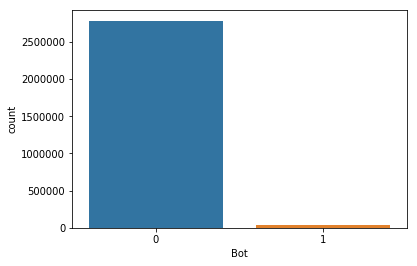

In [0]:
import seaborn as sns
sns.countplot(data=df,x='Bot')

#### There are few ways to balance the classes, I will simply downsample the majority class. This is not the best way to do it but it is less resource intense than other methods.

In [0]:
#Down samplinmg Majority class
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, = train_test_split(df.drop(['Bot'], axis=1), df['Bot'], test_size=.2)

bot_data = x_train[y_train == 1]
normal_data = x_train[y_train == 0]
normal_data_downsampled = normal_data.sample(n=len(bot_data.index))
x_train = pd.concat([bot_data, normal_data_downsampled])
y_train = y_train[x_train.index]

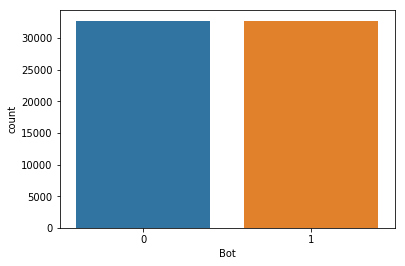

In [0]:
# Lets see the balanced classes
df_temp = x_train.copy()
df_temp["Bot"] = y_train
sns.countplot(data=df_temp,x='Bot')


#### Lets try to run it through a simple model

W0823 00:17:35.864559 140446032176896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 00:17:35.869521 140446032176896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 00:17:35.875154 140446032176896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 00:17:36.073129 140446032176896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Opt


 ********************************** 

65516/65516 [==============================] - 2s 34us/step
Test score: 0.25674804760005215
Test accuracy: 0.9051682031906468
7326/8203(89.31%) were correctly identified as bots
46889/556725 (8.42%) were wrongly identified as bots


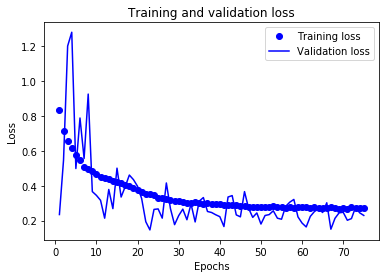

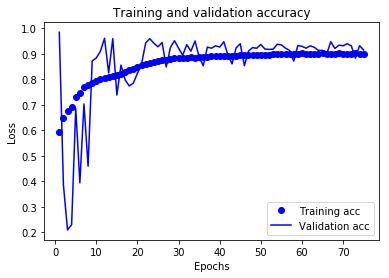

In [0]:
# This creates a simple network of 4 dense layers (3 + output) each with 32 nodes,
# batch_size=128, epochs=75 (see the function below)

run_network(x_train, y_train, x_test, y_test, 32,0)

#### First run looks pretty nice with a loss of 0.27 and accuracy of 0.89. However, it is considered "unsafe" to use features with relatively high values or of very difference ranges (0-1 and 1-1000). These might prevent the network from converging or may just slow it down. 
#### lets have a look on the numerical features and see if that is the case


In [0]:
#lets describe our numerical features: Dur, TotPkts, SrcBytes

def describe_numerical_features(cols):
  df_numerical = pd.DataFrame({'Name':[x.name for x in cols],
                      'Mean':         [x.mean() for x in cols],
                      'Median':       [x.median() for x in cols],
                      'STD':          [x.std() for x in cols],
                      '25%':          [x.quantile(0.25) for x in cols],
                      '75%':          [x.quantile(0.75) for x in cols]})
  display(df_numerical)


describe_numerical_features([df["Dur"],df["TotPkts"],df["SrcBytes"]])
 
  


,Name,Mean,Median,STD,25%,75%
0,Dur,432.205956,0.001194,9.958423e+02,0.000313,9.012607
1,TotPkts,25.479898,2.000000,3.124788e+03,2.000000,4.000000
2,SrcBytes,4155.290128,83.000000,1.858530e+06,78.000000,261.000000


#### As suspected, each feature has a very different range and there is a significant variability and outliers that create an extremely asymmetrical distribution. See, for example, the difference between the mean of the first feature (432) and its median (0.00) which indicates there are quite a few outliers that pull the mean upwards.
#### It is thus recommended to scale the numerical features either by standardization or normalization. 



After Scaling:


,Name,Mean,Median,STD,25%,75%
0,Dur,7.926858e-15,-0.299951,1.000008,-0.300031,-0.287902
1,TotPkts,-3.632046e-15,-0.028903,1.000008,-0.028903,-0.026082
2,SrcBytes,1.553794e-16,-0.013099,1.000008,-0.013192,-0.011718



 ********************************** 

65516/65516 [==============================] - 2s 35us/step
Test score: 0.4908388894522348
Test accuracy: 0.6940747298378962
7976/8203(97.23%) were correctly identified as bots
324713/556725 (58.33%) were wrongly identified as bots


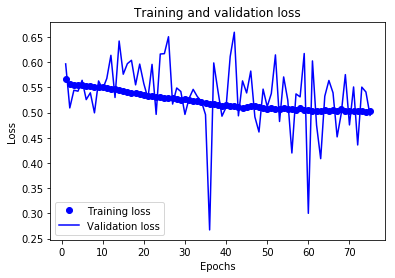

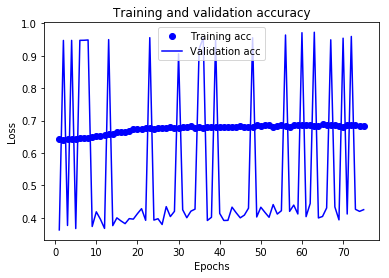

In [0]:
# I will first try a very common scaler that simply substracts the mean and divides by the sd
from sklearn.preprocessing import StandardScaler

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
print("After Scaling:")
#scale using StandartScaler
x_train_scaled, x_test_scaled = scale(x_train.copy(), x_test.copy(), StandardScaler(), numerical_features)
# Show the main statistics
describe_numerical_features([x_train_scaled[col_name] for col_name in numerical_features])
# fit the model again
run_network(x_train_scaled, y_train, x_test_scaled, y_test, netsize=32, verbose=0)


#### The model performs poorly on the scaled data, at least comparing to its performance on the pre-scaled data.
#### I’m not sure what is the reason that it performs worse, but standard scaling doesnt seem to address the main problems with the numerical data -- e.g.  different ranges and high asymmetry due to outliers. 
#### this can be viewed in the following diagrams. 
#### The StandardScaler does improve some of the issues of the with data, but as the skewness of the data shows the distribution remains highly asymmetrical  




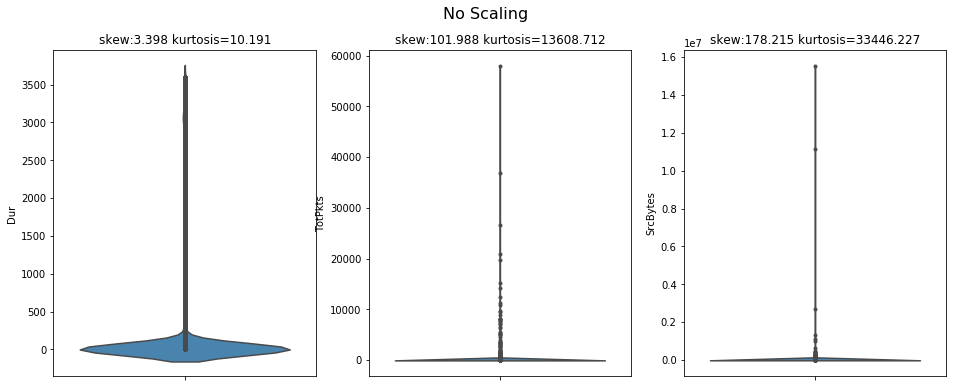

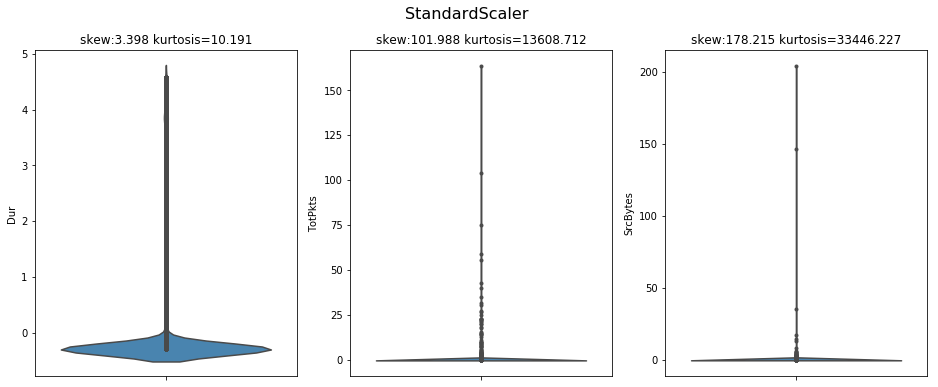

In [0]:
numerical_features = ["Dur","TotPkts","SrcBytes"]
plot_dist(x_train, numerical_features , "No Scaling")
plot_dist(x_train_scaled, numerical_features, "StandardScaler")

#### Now I will try to scale the data using the PowerTransformer which makes the distribution more normal more effectively. 


,Name,Mean,Median,STD,25%,75%
0,Dur,7.453657e-16,-0.630872,1.000008,-0.720391,1.259527
1,TotPkts,1.017605e-13,-0.405114,1.000008,-0.405114,0.457296
2,SrcBytes,2.432139e-14,-0.448030,1.000008,-0.560531,0.483882


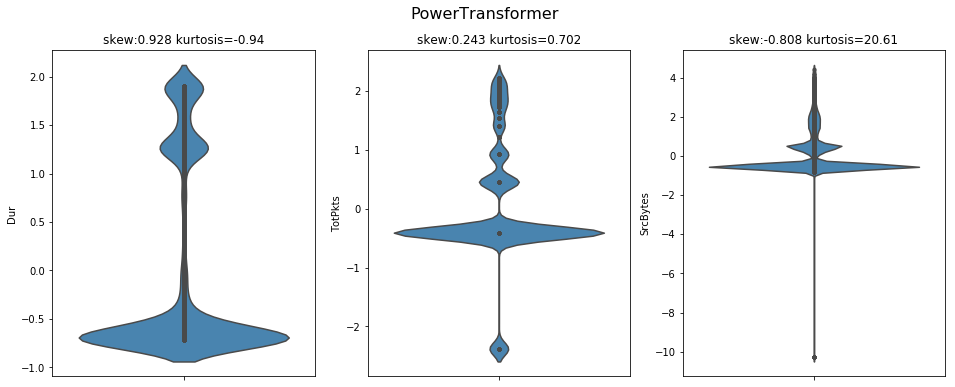

In [0]:
from sklearn.preprocessing import PowerTransformer

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
x_train_normalized, x_test_normalized = scale(x_train.copy(), x_test.copy(), PowerTransformer(), numerical_features)
describe_numerical_features([x_train_normalized[col_name] for col_name in numerical_features])
#plot it
plot_dist(x_train_normalized,numerical_features, "PowerTransformer")



#### The PowerTransformer has significantly "improved" skewness and value range of the data. Now lets try to run the same model on the scaled data


 ********************************** 

65516/65516 [==============================] - 2s 34us/step
Test score: 0.21556821397623233
Test accuracy: 0.9167684229842851
7339/8203(89.47%) were correctly identified as bots
37005/556725 (6.65%) were wrongly identified as bots


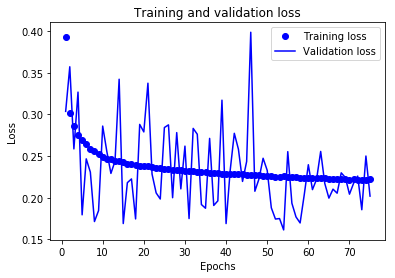

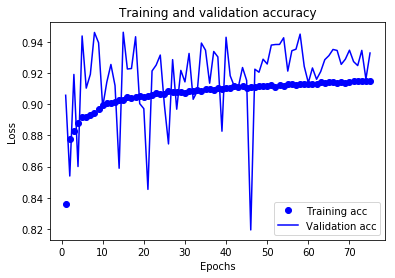

In [0]:
run_network(x_train_normalized, y_train, x_test_normalized, y_test, netsize=32, verbose=0)

##### There is some improvement comparing to the first model (loss went down from 0.256 to 0.215 and accuracy when up from 0.905 to 0.916), though it also seem "safer" given the fact that real data may range and vary quite significantly. 

## Helper Functions:Run this first!

In [0]:
# Plotting functions

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns


def print_perc(tn,tp,fn,fp):
    actual_true = tp + fn
    pr_t = round((tp / actual_true * 100), 2)
    actual_false = tn + fp
    pr_f = round((fp / actual_false * 100), 2)
    print(f"{tp}/{actual_true}({pr_t}%) were correctly identified as bots")
    print(f"{fp}/{actual_false} ({pr_f}%) were wrongly identified as bots")


def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()   
    
def plot_accuracy(history):
    plt.clf()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)  
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_dist(df, features, title):
    f, axs = plt.subplots(ncols=len(features), figsize=(16,6), sharey=False, sharex=False)
    for i, ax in enumerate(axs):
      sns.violinplot(data=df, y=features[i], inner="point", palette="Blues_d",  ax=ax)
      ax.set_title(f"skew:{round(skew(df[features[i]]),3)} kurtosis={round(kurtosis(df[features[i]]),3)}")
    f.suptitle(title, fontsize=16)
    plt.show()



## Training and Scaling Functions

In [0]:

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import confusion_matrix

def run_network(xtrain, ytrain, xtest, ytest, netsize=16, verbose=0):

  classifier = Sequential()
  #  First Hidden Layer
  classifier.add(Dense(netsize, activation='relu', input_dim=14))
  # Second  Hidden Layer
  classifier.add(Dense(netsize, activation='relu'))
  # Third  Hidden Layer
  classifier.add(Dense(netsize, activation='relu'))
  # Output Layer
  classifier.add(Dense(1, activation='sigmoid'))
  # Compiling the neural network
  classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  # Fitting the data to the training dataset
  history = classifier.fit(xtrain,
                         ytrain,
                         batch_size=128,
                         epochs=75,
                         validation_data=(xtest, ytest),
                         verbose=verbose)

  print("\n ********************************** \n")
  score, acc = classifier.evaluate(xtrain, ytrain)
  print('Test score:', score)
  print('Test accuracy:', acc)
  y_pred = classifier.predict(xtest)
  y_pred = (y_pred > 0.5)
  tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
  print_perc(tn, tp, fn, fp)
  plot_loss(history)
  plot_accuracy(history)
  
  


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

def scale(xtrain, xtest, transformer, numerical_f):
  if(transformer != None):
    for col in numerical_f:
      data = xtrain[col]
      test_data = xtest[col]
      transformer.fit(data.values.reshape(-1,1))
      xtrain[col] = transformer.transform(data.values.reshape(-1,1))
      xtest[col] = transformer.transform( test_data.values.reshape(-1,1))
  return xtrain, xtest
  
    
  


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install seaborn